In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ~/workspace/theislab/mubind/notebooks/scatac

/mnt/c/Users/ignacio.ibarra/Dropbox/workspace/theislab/mubind/notebooks/scatac


In [3]:
import mubind as mb
import numpy as np
import pandas as pd
import torch
import bindome as bd
bd.constants.ANNOTATIONS_DIRECTORY = 'annotations'
# mb.models.MultiBind
import torch.optim as topti
import torch.utils.data as tdata
import matplotlib.pyplot as plt
import logomaker
import os
import scipy
import pickle

# Use a GPU if available, as it should be faster.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

Using device: cuda:0


In [4]:
atac_path = '../../annotations/scatac/pancreas_multiome_2022_processed_sample_10000.h5ad'
os.path.exists(atac_path)

True

In [5]:
import scanpy as sc
adata = sc.read_h5ad(atac_path)

In [6]:
adata.shape

(10000, 10000)

In [7]:
adata.shape

(10000, 10000)

In [8]:
adata = adata[:,adata.var.modality == 'ATAC'].copy()

n_sample_cells = 1000
n_sample_peaks = 1000
obs_sample = pd.Series(adata.obs_names).sample(n_sample_cells)
var_sample = pd.Series(adata.var_names).sample(n_sample_peaks)

adata = adata[adata.obs_names.isin(obs_sample),adata.var_names.isin(var_sample)]

In [9]:
adata.shape

(1000, 1000)

In [10]:
adata.shape

(1000, 1000)

/home/rio/miniconda3/envs/mubind/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


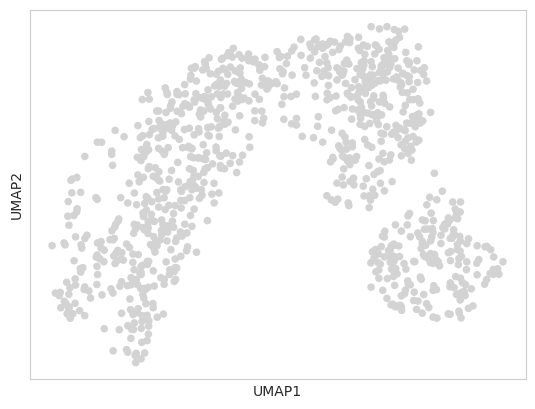

In [11]:
sc.pl.umap(adata)

In [12]:
adata.var

,modality
1-12436160-12436930,ATAC
1-15926066-15927582,ATAC
1-16309056-16309913,ATAC
1-22487039-22487906,ATAC
1-25075850-25076744,ATAC
...,...
X-140242689-140243612,ATAC
X-152089565-152090490,ATAC
X-164441095-164441983,ATAC
X-168639334-168640261,ATAC


In [13]:
adata.var['chr'] = 'chr' + adata.var_names.str.split('-').str[0]
adata.var['start'] = adata.var_names.str.split('-').str[1].astype(int)
adata.var['end'] = adata.var_names.str.split('-').str[2].astype(int)

/tmp/ipykernel_9890/2332568260.py:1: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['chr'] = 'chr' + adata.var_names.str.split('-').str[0]


In [14]:
extend = 50

adata.var['chr'].value_counts()

chr1     73
chr6     64
chr2     63
chr10    63
chr9     63
chr11    63
chr4     63
chr8     55
chr3     53
chr7     52
chr5     51
chr15    45
chr14    44
chr12    43
chr18    42
chr16    41
chr17    41
chr13    32
chr19    25
chrX     24
Name: chr, dtype: int64

In [15]:
adata.var['summit'] = ((adata.var['end'] + adata.var['start']) / 2).astype(int)
adata.var['summit.start'] = adata.var['summit'] - extend
adata.var['summit.end'] = adata.var['summit'] + extend

In [16]:
adata.var['k.summit'] = adata.var['chr'] + ':' + adata.var['summit.start'].astype(str) + '-' + adata.var['summit.end'].astype(str)

In [17]:
adata.shape

(1000, 1000)

In [18]:
n_seqs = 10000 # adata.shape[1] # None # 1000
seqs = mb.bindome.tl.get_sequences_from_bed(adata.var[['chr', 'summit.start', 'summit.end']].head(n_seqs), genome='mm10', uppercase=True,
                                            gen_path='../../annotations/mm10/genome/mm10.fa')
keys = set([s[0] for s in seqs])
adata = adata[:,adata.var['k.summit'].isin(keys)]
# seqs = [[s[0], s[1].upper()] for s in seqs[0]]

/tmp/tmpnt_ee386
genome mm10 True
../../annotations/mm10/genome/mm10.fa
True ../../annotations/mm10/genome/mm10.fa
running bedtools...
bedtools getfasta -fi ../../annotations/mm10/genome/mm10.fa -bed /tmp/tmpnt_ee386 -fo /tmp/tmp9huqnutn


In [19]:
len(seqs)

1000

In [20]:
# remove Ns
for s in seqs:
    if 'N' in s:
        assert False
    # seqs = [[s[0], s[1].replace('N', '')] for s in seqs]
counts = adata.X.T

In [21]:
next_data = pd.DataFrame(counts.A) # sparse.from_spmatrix(counts.A)
# next_data = pd.DataFrame.sparse.from_spmatrix(counts)# var = []
# for ri, r in next_data.iterrows():
#     if ri % 1000 == 0:
#         print(ri, next_data.shape)
#     # print(ri, r.values[:-1], r.values[:-1].var())
#     var.append(r.values[:-1].var())
#     # break



In [22]:
next_data['var'] = next_data.var(axis=1)
# next_data = next_data[range(100)].copy()

In [23]:
next_data.index = [s[1] for s in seqs]
next_data.index.name = 'seq'
next_data.shape

(1000, 1001)

In [24]:
# sum_index = next_data[next_data.columns[:-1]].var(axis=1).sort_values(ascending=False).index

In [25]:
n_cells = 10000
top_var = next_data[['var']].sort_values('var', ascending=False).index[:n_cells]

In [26]:
# next_data = next_data.head(10000)
next_data_sel = next_data.reindex(top_var) # .reset_index(drop=True)

In [27]:
next_data_sel

,0,1,2,3,4,5,6,7,8,9,...,991,992,993,994,995,996,997,998,999,var
seq,,,,,,,,,,,,,,,,,,,,,
GCCCAATGAAGCGCGAGTTCCACCTTCTCGGGGCGGCTCTAGGATGAGAGTGACGGCTCTGATCAGTCACGTGGCCTTGAGGGCGGAGCCTATGAAAATT,2.0,2.0,6.0,5.0,3.0,0.0,3.0,4.0,1.0,2.0,...,7.0,4.0,2.0,4.0,3.0,1.0,2.0,0.0,1.0,2.939564
TAGGCACGGCGAGCTGTCACTCCGCCGCATCGCCCCGCCCCCTGGCCCCCCACCCCTGCGGGCGCGACCCCGGCCGAGGGGCGGGCCGGAGTCGCCCGAC,3.0,4.0,2.0,4.0,3.0,4.0,2.0,3.0,2.0,5.0,...,4.0,1.0,2.0,2.0,0.0,3.0,2.0,0.0,3.0,2.085805
GGCGCGCAGGGAAGGAAGAGAGGGAGGGGCGCGCGGAGGCGCGAGTCGCCCGCCCCGCACTACAGGCCACCCTTTCCACACCGCGCGCTGCAAGTTCTGA,2.0,3.0,0.0,2.0,3.0,1.0,2.0,3.0,0.0,0.0,...,2.0,2.0,1.0,0.0,4.0,1.0,0.0,0.0,1.0,1.990390
TGCCTCCGGGGCGGGACCGAGTAACGAGCCAATGGGGCGTGGTGGGAGAAGGGTCGCCAATGGGAGTGGGCATGGGGCGGGAGACACACGCCTCCGAGCT,2.0,0.0,3.0,3.0,2.0,0.0,1.0,1.0,0.0,2.0,...,1.0,2.0,4.0,1.0,0.0,1.0,0.0,1.0,0.0,1.824240
ATGCGAAAGTTTTTTTTTTTTTTGACCGCTCTAGCGAGGGCCAATAGAAACTTTGGTTCAGGATTGACAGTTTGTGCAAGCCTCTTGACAGCAGTCCTGT,1.0,1.0,0.0,5.0,3.0,1.0,2.0,0.0,2.0,2.0,...,1.0,1.0,1.0,1.0,0.0,0.0,2.0,0.0,2.0,1.640271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AGGACTCATTGGTCACAACATCATACCTAATTAGCATGTGGGCAGGAAGGGTTGATGGATCACAATACAGTGCCTAATTATCATGCAGGTTATCCCAGAG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002994
ACGAGGCTCACAGGATGGCAAATGCTAGGGGGTTCCAGGTCATACCTAATAAGATAGAATCACATGCAACCTACCATAACAGGTCTCAAGGACACCAGTG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002994
ATGCTCTGCAGCTGCATTCAGGAGTCCTACTCTTTGAAGTATAGAATTAATAGTTGAATGATATACCTCAAAGCATGGCCCATAAGGCAGGCAGCGGGTG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001998


In [28]:
del next_data_sel['var']
# next_data_sel.index = next_data_sel['seq']
# del next_data_sel['seq']

In [29]:
df = next_data_sel.copy() # sample
# df = df[df.columns[:5000]] # .head(100) # sample

# shorten sequences/remove duplicates
# df.index = df.index.astype(str).str[35:-35]
# df = df[~df.index.duplicated(keep='first')]

zero_counts = df.sum(axis=1) == 0
df = df[~zero_counts] # remove zeroes

df.shape

(1000, 1000)

In [30]:
df2 = df.reset_index().melt('seq').set_index('seq')
# add a baseline count
df2[0] = 1.0
cols = ['batch', 1, 0]
df2.columns = cols
df2 = df2[[0, 1, 'batch']] # cols[::-1]]
df2['batch'] = df2['batch'].astype(int)
print(df2.shape)
print(len(set(df2['batch'])))
n_cells = 200
df2 = df2[df2['batch'].isin(range(0, n_cells))]
print(df2['batch'].value_counts())
df2.head()

(1000000, 3)
1000
0      1000
137    1000
127    1000
128    1000
129    1000
       ... 
69     1000
70     1000
71     1000
72     1000
199    1000
Name: batch, Length: 200, dtype: int64


,0,1,batch
seq,,,
GCCCAATGAAGCGCGAGTTCCACCTTCTCGGGGCGGCTCTAGGATGAGAGTGACGGCTCTGATCAGTCACGTGGCCTTGAGGGCGGAGCCTATGAAAATT,1.0,2.0,0
TAGGCACGGCGAGCTGTCACTCCGCCGCATCGCCCCGCCCCCTGGCCCCCCACCCCTGCGGGCGCGACCCCGGCCGAGGGGCGGGCCGGAGTCGCCCGAC,1.0,3.0,0
GGCGCGCAGGGAAGGAAGAGAGGGAGGGGCGCGCGGAGGCGCGAGTCGCCCGCCCCGCACTACAGGCCACCCTTTCCACACCGCGCGCTGCAAGTTCTGA,1.0,2.0,0
TGCCTCCGGGGCGGGACCGAGTAACGAGCCAATGGGGCGTGGTGGGAGAAGGGTCGCCAATGGGAGTGGGCATGGGGCGGGAGACACACGCCTCCGAGCT,1.0,2.0,0
ATGCGAAAGTTTTTTTTTTTTTTGACCGCTCTAGCGAGGGCCAATAGAAACTTTGGTTCAGGATTGACAGTTTGTGCAAGCCTCTTGACAGCAGTCCTGT,1.0,1.0,0


### This is the relatedness graph and used for dynamics filters learning

In [31]:
# sum(adata.obs_names.isin(df.index)

In [32]:
len(seqs)

1000

In [33]:
rel = adata[:,~zero_counts].uns['neighbors']['connectivities'].A
# rel[:n_cells,:n_cells].sum()
rel.shape

/tmp/ipykernel_9890/4129523788.py:1: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  rel = adata[:,~zero_counts].uns['neighbors']['connectivities'].A


(1000, 1000)

In [34]:
rel.shape

(1000, 1000)

In [35]:
# df2 = []
# for i in df.columns:
#     df3 = df[[i]].copy()
#     df3 = df3.head(100)
#     df3.columns = [0]
#     df3[1] = 1 # need a minimal non-zero count
#     df3['batch'] = i
#     df2.append(df3)
# df2 = pd.concat(df2)
# # df2['is_count_data'] = True
# dataset = mb.datasets.SelexDataset(df2, n_rounds=2, labels=[0, 1], enr_series=False)
dataset = mb.datasets.SelexDataset(df, n_rounds=df.shape[1], enr_series=False)
len(set(dataset.batch))

1

In [36]:
n_batch = len(set(dataset.batch))
n_batch

1

In [37]:
# df = next_data_sel.copy()
# dataset = mb.datasets.GenomicsDataset(df)
# train = tdata.DataLoader(dataset=dataset, batch_size=1000, shuffle=True)

train = tdata.DataLoader(dataset=dataset, batch_size=1024, shuffle=True)


In [38]:
# log_etas = torch.tensor(np.log(df.sum(axis=0) / df.sum().sum())).reshape(1, n_batch).to(device)
# log_etas

In [39]:
b = np.random.randint(0, 2, (3, 4))
conn = np.random.randint(0, 2, (4, 4))

In [44]:
import torch.optim as topti
import warnings
warnings.filterwarnings("ignore")

criterion = mb.tl.PoissonLoss()

n_kernels = 16
model = mb.models.Multibind.make_model(train, n_kernels, criterion, kernels=[0, 2] + [20] * (n_kernels - 2),
                                       # use_dinuc=True, dinuc_mode='full',
                                       optimize_sym_weight=False,
                                       optimize_exp_barrier=True,
                                       optimize_log_dynamic=False,
                                       use_dinuc=False,
                                       device=device,
                                       dinuc_mode=None).cuda()

# Init
def triu_init(m):
    with torch.no_grad():
        m.weight.copy_(torch.triu(m.weight))

# Zero out gradients
def get_zero_grad_hook(mask):
    def hook(grad):
        return grad * mask

    return hook

mask = torch.tril(torch.ones_like(model.selex_module.log_dynamic), -1)
print(mask.device)
print(model.selex_module.log_dynamic)

model.selex_module.log_dynamic.register_hook(get_zero_grad_hook(mask))


# here we set up the relationships between cells using the knn graph, for graph-based learning of activities
model.selex_module.connectivities = torch.tensor(rel).cuda()

cuda:0
Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0', requires_grad=True)


In [45]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [46]:
# %lprun -f model.selex_module.forward model.optimize_iterative(train, n_epochs=[500] + [200] * (n_kernels - 1), show_logo=False, use_mono=True, use_dinuc=False)

In [ ]:
model, best_loss = model.optimize_iterative(train, n_epochs=[500] + [200] * (n_kernels - 1), show_logo=False, use_mono=True, use_dinuc=False, dinuc_mode='local',
                                            opt_kernel_shift=[0, 0] + [1] * (n_kernels - 2),
                                            opt_kernel_length=[0, 0] + [1] * (n_kernels - 2),
                                            shift_max=1, shift_step=1, optimiser=topti.Adam,
                                            n_batches=1, n_rounds=2, num_epochs_shift_factor=1, # log_etas=log_etas, # log_etas=log_etas,
                                            kernels = [0] + [2] + [20] * (n_kernels - 2), r2_per_epoch=True,
                                            exp_max=8,
                                            early_stopping=50, log_each=10, w=20, max_w=20) #  target_dim=train.dataset.signal.shape[1])

current kernels

Kernel to optimize 0

FREEZING KERNELS
optimizing feature type mono
setting grad status of kernel (mono, dinuc) at 0 to (1, 0)
setting grad status of kernel (mono, dinuc) at 1 to (0, 0)
setting grad status of kernel (mono, dinuc) at 2 to (0, 0)
setting grad status of kernel (mono, dinuc) at 3 to (0, 0)
setting grad status of kernel (mono, dinuc) at 4 to (0, 0)
setting grad status of kernel (mono, dinuc) at 5 to (0, 0)
setting grad status of kernel (mono, dinuc) at 6 to (0, 0)
setting grad status of kernel (mono, dinuc) at 7 to (0, 0)
setting grad status of kernel (mono, dinuc) at 8 to (0, 0)
setting grad status of kernel (mono, dinuc) at 9 to (0, 0)
setting grad status of kernel (mono, dinuc) at 10 to (0, 0)
setting grad status of kernel (mono, dinuc) at 11 to (0, 0)
setting grad status of kernel (mono, dinuc) at 12 to (0, 0)
setting grad status of kernel (mono, dinuc) at 13 to (0, 0)
setting grad status of kernel (mono, dinuc) at 14 to (0, 0)
setting grad status of ke

True
2


IndexError: GridSpec slice would result in no space allocated for subplot

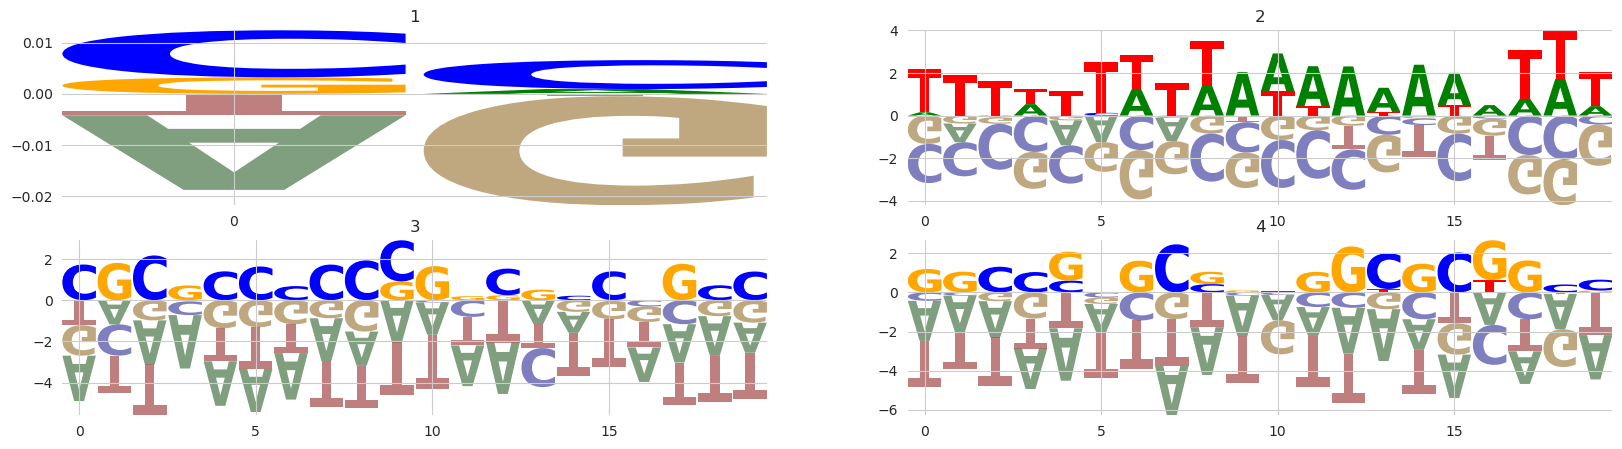

In [59]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 20, 5
rcParams['figure.dpi'] = 100
mb.pl.conv(model, n_cols=2, show=True)
plt.show()


In [ ]:
log_dynamic = model.selex_module.log_dynamic
log_dynamic = log_dynamic + -torch.transpose(log_dynamic, 0, 1)
# triu_indices = torch.triu_indices(row=n_rounds, col=n_rounds, offset=1)
log_dynamic

In [ ]:
import seaborn as sns
mb.pl.set_rcParams({'figure.figsize': [3, 3]})
sns.heatmap(log_dynamic.detach().cpu(), cmap='RdBu_r')

In [ ]:
# contributions per newly added kernel
rcParams['figure.figsize'] = 2, 3
rcParams['figure.dpi'] = 80
import seaborn as sns
r2 = pd.DataFrame(model.best_r2_by_new_filter, columns=['r2']).reset_index()
sns.barplot(data=r2, x='index', y='r2')

In [ ]:
log_dynamic = model.selex_module.log_dynamic
log_dynamic

In [ ]:
torch.set_printoptions(precision=2)
log_dynamic = log_dynamic.detach().cpu().numpy()

n_rounds = model.selex_module.n_rounds
triu_indices = torch.triu_indices(row=n_rounds, col=n_rounds, offset=1)
log_dynamic[triu_indices[0], triu_indices[1]] = 0
dynamic_score = log_dynamic.sum(axis=0)


In [ ]:

# dyn_score
dynamic_score = dynamic_score
dynamic_score = (dynamic_score - dynamic_score.min()) / (dynamic_score.max() - dynamic_score.min())
adata.obs['dynamic_score'] = dynamic_score

In [ ]:
# contributions per newly added kernel
rcParams['figure.figsize'] = 5, 5
rcParams['figure.dpi'] = 120
sc.pl.umap(adata, color='dynamic_score', cmap='RdBu_r', sort_order=True)


In [ ]:
mb.pl.kmer_enrichment(model, train, log_scale=False, style='scatter', ylab='t1', xlab='p1')

In [ ]:
import resource
print('total GB used:', resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1e6)
